In [2]:
import numpy as np
import pyro
import pyro.distributions as dist

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
from scipy.stats import binom, beta, pareto
import pickle

### 1D Binomial mixture model

In [2]:
def binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k]).log_prob(NV) # put on each column of lk a different data; rows are the clusters
    return lk

def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters) to so obtain a single likelihood for each data

In [3]:
def binom_model(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()

    # prior for mixing proportions
    alpha = torch.ones(K)

    # Mixing proportions
    weights = pyro.sample("weights", dist.Dirichlet(alpha)) # i weights non vanno dentro al plate perchè l'output deve essere un vettore di elementi non indipendenti (perchè sommano a 1)

    # Prior for success probability of each binomial component
    with pyro.plate("plate_probs", K):
        probs = pyro.sample("probs", dist.Beta(1, 1)) # assume Beta prior for the binomial success probabilities
        # print(probs)

    # Plate for the data
    with pyro.plate("plate_data", len(data)):
        pyro.factor("lik", log_sum_exp(binomial_lk(probs, DP, weights, K, NV)).sum()) # .sum() sums over the data because we have a log-likelihood

In [4]:
def binom_guide(data, K):

    # Mixing proportions
    # in pyro.param usa .sample() perchè non vuole semplicemente la prior ma vuole dei sample.
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K)).sample(), constraint=constraints.simplex)
    weights = pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    # Probabilities of success with Beta(1,1) prior
    probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K), torch.ones(K)).sample(), constraint=constraints.interval(0.,1.))
    print(probs_param)
    
    # Probability of success for each component
    with pyro.plate("plate_probs", K):
        pyro.sample("probs", dist.Delta(probs_param))

In [5]:
# Create the dataset with two binomial components
# data: [NV, DP]
g1 = torch.ones([100, 2]) * 100 # 33% data from binomial 1
g2 = torch.ones([200, 2]) * 200 # 66% data from binomial 2

In [6]:
g1[:,0] = dist.Binomial(total_count=100, probs=torch.tensor([.2])).sample([100]).squeeze(-1)
g2[:,0] = dist.Binomial(total_count=200, probs=torch.tensor([.6])).sample([200]).squeeze(-1)
d_example = torch.concat((g1,g2))
# d_example

In [8]:
# Run inference
pyro.clear_param_store()
svi = pyro.infer.SVI(binom_model, binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 2000
for i in range(num_iterations):
    loss = svi.step(d_example, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

tensor([0.3384, 0.1066], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 2220544.0
tensor([0.3386, 0.1067], grad_fn=<ClampBackward1>)
tensor([0.3388, 0.1068], grad_fn=<ClampBackward1>)
tensor([0.3390, 0.1069], grad_fn=<ClampBackward1>)
tensor([0.3393, 0.1070], grad_fn=<ClampBackward1>)
tensor([0.3395, 0.1071], grad_fn=<ClampBackward1>)
tensor([0.3397, 0.1072], grad_fn=<ClampBackward1>)
tensor([0.3399, 0.1073], grad_fn=<ClampBackward1>)
tensor([0.3402, 0.1074], grad_fn=<ClampBackward1>)
tensor([0.3404, 0.1075], grad_fn=<ClampBackward1>)
tensor([0.3406, 0.1076], grad_fn=<ClampBackward1>)
tensor([0.3408, 0.1077], grad_fn=<ClampBackward1>)
tensor([0.3411, 0.1078], grad_fn=<ClampBackward1>)
tensor([0.3413, 0.1079], grad_fn=<ClampBackward1>)
tensor([0.3415, 0.1080], grad_fn=<ClampBackward1>)
tensor([0.3417, 0.1081], grad_fn=<ClampBackward1>)
tensor([0.3420, 0.1082], grad_fn=<ClampBackward1>)
tensor([0.3422, 0.1083], grad_fn=<ClampBackward1>)
tensor([0.3424, 0.1084], grad_fn=<ClampBackward1>)
t

In [9]:
# Print learned parameters
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.6659, 0.3341], grad_fn=<DivBackward0>)
probs_param tensor([0.5978, 0.2104], grad_fn=<ClampBackward1>)


In [11]:
# Extract learned parameters
probs = pyro.param("probs_param").detach().numpy()
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success: ", probs)
print("Mmixing proportions: ", weights)

Probabilities of success:  [0.5977877  0.21039617]
Mmixing proportions:  [0.6659246 0.3340754]


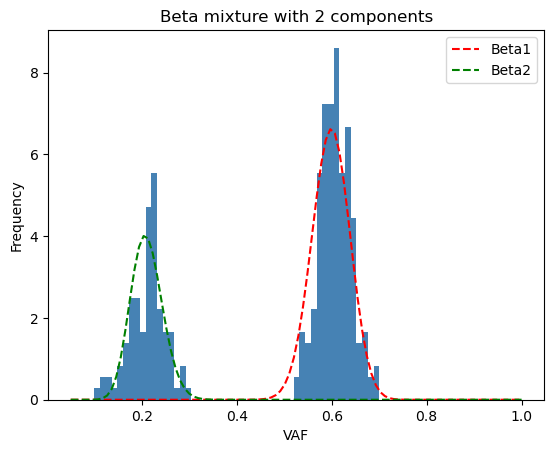

In [16]:
# Plot histogram of data
VAF = d_example[:,0]/d_example[:,1]
plt.hist(VAF, bins=50, density = True, color='steelblue')

# Plot densities
x = np.linspace(0.05, 1, 100)
num_components = 2
n = 150

density1 = beta.pdf(x, n*probs[0], n*(1-probs[0])) * weights[0] # sample data from beta distribution with learned parameters
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = beta.pdf(x, n*probs[1], n*(1-probs[1])) * weights[1] # sample data from beta distribution with learned parameters
plt.plot(x, density2, linewidth=1.5, label=f'Beta2', linestyle='--', color='g')

plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.title("Beta mixture with 2 components")
plt.legend()
plt.show()

### 1D Binomial Pareto model

In [30]:
# Load pkl data
# These data contains a mixture with 1 Pareto and 2 beta components 
def load_example_data(directory = "./"):
    flh = open(directory + "example.pkl", "rb")
    inp = pickle.load(flh)
    inp = {k: v.float().round() for k, v in zip(inp.keys(), inp.values())}
    return inp

In [31]:
data = load_example_data("./")
len(data["1:1"])

961

In [32]:
data

{'1:1': tensor([[  7., 112.],
         [  6., 101.],
         [  7., 106.],
         ...,
         [ 47., 114.],
         [ 64., 121.],
         [ 66., 138.]])}

In [33]:
data = data["1:1"]

In [34]:
data.shape

torch.Size([961, 2])

In [105]:
def binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rown and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k]).log_prob(NV) # put on each column of lk a different data; rows are the clusters
    return lk

def pareto_lk(p, NV, DP):
    return dist.Binomial(probs=p, total_count=DP).log_prob(NV)

def final_lk(pareto, binomial, weights):
    if len(binomial.shape) == 1:
        dim0, dim1 = 1,binomial.shape[0] # dim0 is the number of beta peaks, dim1 is the number of data (mutations) -> this comes from the binomial_lk() function
    else:
        dim0, dim1 = binomial.shape[0], binomial.shape[1]
    # print(dim0, dim1)
    
    lk = torch.ones(1 + dim0, dim1) # creates a matrix: rows with number of binomial peaks+1 (pareto), columns with data.
                                    # So the rows will represent the components (with correspondent weights) and the columns represent the data
    lk[0, :] = torch.log(weights[0]) + pareto
    # print(weights[1:].shape, binomial.shape)

    w_sum = weights[1:].sum()
    lk[1:(1 + dim1), :] = torch.log(w_sum) + binomial.unsqueeze(0)
    # lk[1:(1 + dim1), :] = torch.log(weights[1:]) + binomial
    return lk


def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

In [106]:
from pyro.distributions import Rejector, Pareto
# Rejector: Rejection sampled distribution given an acceptance rate function.

# BoundedPareto taken form MOBSTERH
class BoundedPareto(Rejector):
    def __init__(self, scale, alpha, upper_limit, validate_args=False):
        propose = Pareto(scale, alpha, validate_args=validate_args)

        def log_prob_accept(x):
            return (x <= upper_limit).type_as(x).log()
        # log_prob_accept: This is a function that computes the logarithm of the acceptance probability for a given value x. 
        # It checks if x is less than or equal to the upper_limit. 
        # If x is within the specified range, the function returns the log of 1 (acceptance probability is 1). 
        # Otherwise, it returns the log of 0 (acceptance probability is 0).

        # log_scale = torch.Tensor(alpha) * torch.log(torch.Tensor([scale / upper_limit]))
        log_scale = 0
        super(BoundedPareto, self).__init__(propose, log_prob_accept, log_scale)

In [107]:
def binom_pareto_model(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()
    VAF = NV/DP 

    # prior for Pareto shape parameter (alpha_pareto)
    alpha = pyro.sample("alpha_pareto", dist.LogNormal(0,100))
    probs_pareto = pyro.sample("probs_pareto", BoundedPareto(torch.min(VAF) - 1e-5, alpha, 1))
    # probs_pareto = pyro.sample("probs_pareto", dist.Pareto(torch.min(VAF) - 1e-5, alpha))

    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K+1)))

    # Prior for success probability of each component
    with pyro.plate("plate_probs", K):
        probs = pyro.sample("probs", dist.Beta(1, 1)) # assume Beta prior for the success probabilities
        # print(probs)

    # Plate for the data
    with pyro.plate("plate_data", len(data)):
        binomial = binomial_lk(probs, DP, weights[1:], K, NV)
        pareto = pareto_lk(probs_pareto, NV, DP)
        pyro.factor("lik", log_sum_exp(final_lk(pareto, binomial, weights)).sum()) # .sum() sums over the data because we have a log-likelihood


In [108]:
def binom_pareto_guide(data, K):
    NV = data[:,0].int()
    DP = data[:,1].int()
    VAF = NV/DP
    
    # Mixing proportions to be learned
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K+1)).sample(), constraint=constraints.simplex)
    weights = pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K), torch.ones(K)).sample(), constraint=constraints.interval(0.,1.))

    # Pareto
    # alpha_param = pyro.param("alpha_param", dist.LogNormal(0,100).sample(), constraint=constraints.positive) # with LogNormal it does not work, check
    alpha_param = pyro.param("alpha_param", torch.tensor(0.8), constraint=constraints.positive) # Use 0.8 as starting value
    pyro.sample("alpha_pareto", dist.Delta(alpha_param))
    
    # Using param for this probability it does not learn the right parameters, I do not know why
    # probs_pareto_param = pyro.param("probs_pareto_param", BoundedPareto(torch.min(VAF) - 1e-5, alpha_param, 1).sample(), constraint=constraints.interval(0.,1.))
    # pyro.sample("probs_pareto", dist.Delta(probs_pareto_param))
    pyro.sample("probs_pareto", BoundedPareto(torch.min(VAF) - 1e-5, alpha_param, 1))
    
    # Probability of success for each beta component
    with pyro.plate("plate_probs", K):
        pyro.sample("probs", dist.Delta(probs_param))

In [109]:
# Run inference
pyro.clear_param_store()
svi = pyro.infer.SVI(binom_pareto_model, binom_pareto_guide, pyro.optim.Adam({"lr": 0.01}), pyro.infer.TraceGraph_ELBO())
num_iterations = 3000
for i in range(num_iterations):
    loss = svi.step(data, K=1)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

Iteration 0: Loss = 24183418.0
Iteration 100: Loss = 38402016.0
Iteration 200: Loss = 16382365.0
Iteration 300: Loss = 7076681.5
Iteration 400: Loss = 4741486.0
Iteration 500: Loss = 5123930.0
Iteration 600: Loss = 4368314.5
Iteration 700: Loss = 4369308.5
Iteration 800: Loss = 4719802.5
Iteration 900: Loss = 4915904.5
Iteration 1000: Loss = 5064776.0
Iteration 1100: Loss = 18452452.0
Iteration 1200: Loss = 5000326.0
Iteration 1300: Loss = 5299770.5
Iteration 1400: Loss = 4407922.0
Iteration 1500: Loss = 5112594.5
Iteration 1600: Loss = 4912262.5
Iteration 1700: Loss = 4898350.5
Iteration 1800: Loss = 5337990.5
Iteration 1900: Loss = 5411963.0
Iteration 2000: Loss = 5089210.5
Iteration 2100: Loss = 4327175.5
Iteration 2200: Loss = 4529639.0
Iteration 2300: Loss = 4769827.5
Iteration 2400: Loss = 5284553.5
Iteration 2500: Loss = 4761371.5
Iteration 2600: Loss = 4307914.5
Iteration 2700: Loss = 4380011.5
Iteration 2800: Loss = 4912142.5
Iteration 2900: Loss = 5358834.5


In [110]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.2457, 0.7543], grad_fn=<DivBackward0>)
probs_param tensor([0.4624], grad_fn=<ClampBackward1>)
alpha_param tensor(3.0759, grad_fn=<AddBackward0>)


In [111]:
# Extract the learned parameters
probs_bin = pyro.param("probs_param").detach().numpy()
alpha_pareto = pyro.param("alpha_param").detach().numpy() 
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", probs_bin)
print("Alpha pareto: ", alpha_pareto)
print("Mmixing proportions: ", weights)

Probabilities of success binomial component:  [0.4623797]
Alpha pareto:  3.0759087
Mmixing proportions:  [0.24574329 0.7542567 ]


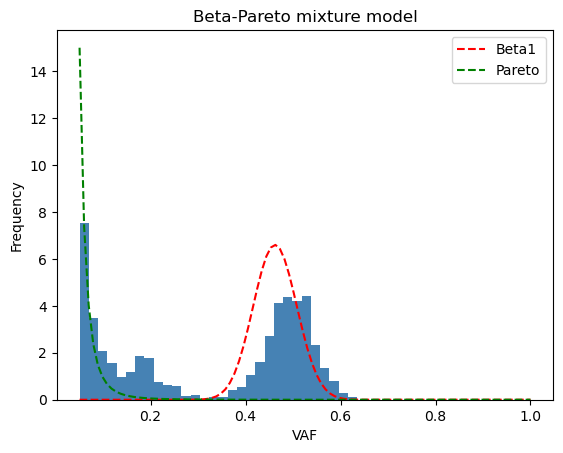

In [114]:
# Plot histogram of data
NV = data[:,0]
DP = data[:,1]
VAF = NV/DP
plt.hist(VAF, bins=30, density=True, color='steelblue')

# Plot densities
x = np.linspace(torch.min(VAF), 1, 100)
num_components = 2
n = torch.mean(DP)

density1 = beta.pdf(x, n*probs_bin[0], n*(1-probs_bin[0])) * weights[1]
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = pareto.pdf(x, alpha_pareto, scale = torch.min(VAF)) * weights[0]
plt.plot(x, density2, linewidth=1.5, label=f'Pareto', linestyle='--', color='g')

plt.title("Beta-Pareto mixture model")
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Using K=2

In [115]:
# Run inference
pyro.clear_param_store()
# svi = pyro.infer.SVI(binom_model, binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceEnum_ELBO())
svi = pyro.infer.SVI(binom_pareto_model, binom_pareto_guide, pyro.optim.Adam({"lr": 0.01}), pyro.infer.TraceGraph_ELBO())
num_iterations = 3000
for i in range(num_iterations):
    loss = svi.step(data, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

Iteration 0: Loss = 12135873.0
Iteration 100: Loss = 5437715.0
Iteration 200: Loss = 4983635.0
Iteration 300: Loss = 4991059.5
Iteration 400: Loss = 7214270.0
Iteration 500: Loss = 4057910.5
Iteration 600: Loss = 4157029.0
Iteration 700: Loss = 3780703.25
Iteration 800: Loss = 3729275.5
Iteration 900: Loss = 3719068.25
Iteration 1000: Loss = 3730468.75
Iteration 1100: Loss = 4717405.0
Iteration 1200: Loss = 3740127.75
Iteration 1300: Loss = 3810319.0
Iteration 1400: Loss = 3761866.75
Iteration 1500: Loss = 3797735.75
Iteration 1600: Loss = 3769837.0
Iteration 1700: Loss = 3795896.25
Iteration 1800: Loss = 3776173.5
Iteration 1900: Loss = 3759757.5
Iteration 2000: Loss = 3808933.75
Iteration 2100: Loss = 3714008.75
Iteration 2200: Loss = 3719598.0
Iteration 2300: Loss = 3715442.75
Iteration 2400: Loss = 3743003.25
Iteration 2500: Loss = 3789244.25
Iteration 2600: Loss = 3749779.75
Iteration 2700: Loss = 3748694.5
Iteration 2800: Loss = 3740845.0
Iteration 2900: Loss = 3788058.5


In [116]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.1447, 0.2189, 0.6364], grad_fn=<DivBackward0>)
probs_param tensor([0.1781, 0.4926], grad_fn=<ClampBackward1>)
alpha_param tensor(5.0964, grad_fn=<AddBackward0>)


In [117]:
# Extract the learned parameters
probs_bin = pyro.param("probs_param").detach().numpy()
alpha_pareto = pyro.param("alpha_param").detach().numpy() 
weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", probs_bin)
print("Alpha pareto: ", alpha_pareto)
print("Mixing proportions: ", weights)

Probabilities of success binomial component:  [0.17814167 0.49264684]
Alpha pareto:  5.0964003
Mixing proportions:  [0.14466944 0.21890073 0.6364298 ]


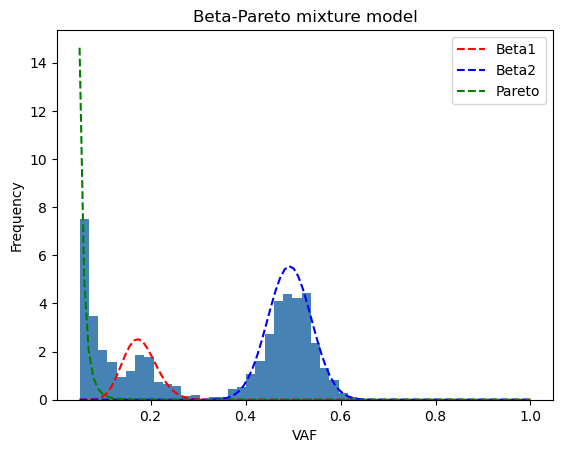

In [119]:
# Plot histogram of data
NV = data[:,0]
DP = data[:,1]
VAF = NV/DP
plt.hist(VAF, bins=30, density=True, color='steelblue')

# Plot densities
x = np.linspace(torch.min(VAF), 1, 100)
n = torch.mean(DP)

# Sample from beta and pareto distributions with the learned parameters
density1 = beta.pdf(x, n*probs_bin[0], n*(1-probs_bin[0])) * weights[1]
plt.plot(x, density1, linewidth=1.5, label=f'Beta1', linestyle='--', color='r')
density2 = beta.pdf(x, n*probs_bin[1], n*(1-probs_bin[1])) * weights[2]
plt.plot(x, density2, linewidth=1.5, label=f'Beta2', linestyle='--', color='b')
density_pareto = pareto.pdf(x, alpha_pareto, scale = torch.min(VAF)) * weights[0]
plt.plot(x, density_pareto, linewidth=1.5, label=f'Pareto', linestyle='--', color='g')

plt.title("Beta-Pareto mixture model")
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Multidimensional binomial model

In [133]:
# Create the dataset
# NV : [NV_s1, NV_s2]
# DP : : [DP_s1, DP_s2]
# DP is fixed inside the model
d1 = torch.ones([1000, 2])
d2 = torch.ones([2000, 2])

In [134]:
d1[:,0] = dist.Binomial(total_count=100, probs=torch.tensor([.1])).sample([1000]).squeeze(-1) # S1 for component 1
d1[:,1] = dist.Binomial(total_count=100, probs=torch.tensor([.3])).sample([1000]).squeeze(-1) # S2 for component 1

d2[:,0] = dist.Binomial(total_count=150, probs=torch.tensor([.4])).sample([2000]).squeeze(-1) # S1 for component 2
d2[:,1] = dist.Binomial(total_count=150, probs=torch.tensor([.6])).sample([2000]).squeeze(-1) # S2 for component 2

NV = torch.concat((d1,d2))
print(NV.shape)
NV

torch.Size([3000, 2])


tensor([[11., 28.],
        [ 8., 25.],
        [18., 25.],
        ...,
        [67., 95.],
        [63., 84.],
        [66., 87.]])

In [135]:
DP1 = torch.ones([1000, 2]) * 100
DP2 = torch.ones([2000, 2]) * 150
DP = torch.concat((DP1,DP2))
print(DP.shape)
DP

torch.Size([3000, 2])


tensor([[100., 100.],
        [100., 100.],
        [100., 100.],
        ...,
        [150., 150.],
        [150., 150.],
        [150., 150.]])

In [136]:
# # Shuffle elements
# idx = torch.randperm(NV.shape[0])
# NV = NV[idx]
# DP = DP[idx]
# NV

In [137]:
print(100*0.2)
print(150*.6)

20.0
90.0


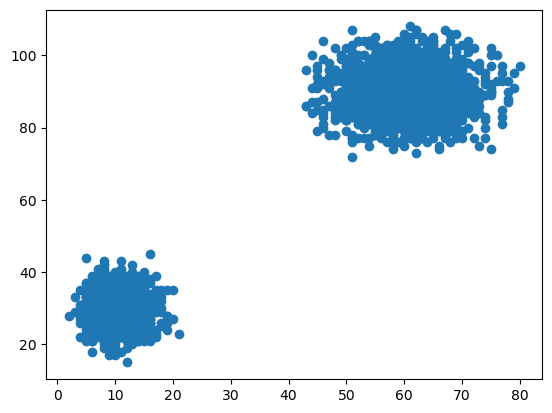

In [138]:
# Plot the data
plt.scatter(NV[:,0], NV[:,1])

Text(0.5, 1.0, 'VAF 2d spectrum')

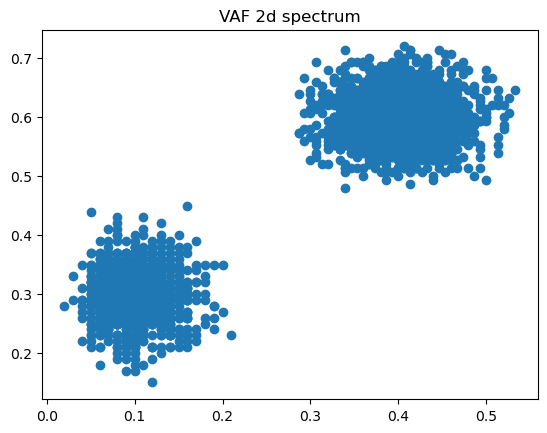

In [139]:
# Plot normalized data (as they were the VAF)
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])
plt.title("VAF 2d spectrum")

In [162]:
# Rewrite binomial likelihood for the multidimensional case
def m_binomial_lk(probs, DP, weights, K, NV):
    lk = torch.ones(K, len(NV)) # matrix with K rows and as many columns as the number of data
    if K == 1:
        return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(NV).sum(axis=1) # simply does log(weights) + log(density)
    for k in range(K):
        lk[k, :] = torch.log(weights[k]) + dist.Binomial(total_count=DP, probs=probs[k, :]).log_prob(NV).sum(axis=1) # sums over the data dimensions (columns)
                                                                                                                 # put on each column of lk a different data; rows are the clusters
    return lk

def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

In [163]:
def m_binom_model(NV, DP, K):
    # NV = data
    # DP = 150 # al momento lo fisso qui, poi sarà preso dai dati
    D = NV.shape[1] # number of dimensions (samples)

    # Prior for the mixing weights
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K)))

    # Prior for success probabilities (each probability has 2 dimensions) for each component
    with pyro.plate("plate_probs", K):
        probs = pyro.sample("probs", dist.Beta(1, 1).expand([D]).to_event(1)) # assume Beta prior for the success probabilities
        # probs = pyro.sample("probs", dist.Beta(torch.ones(K, d), torch.ones(K, d)))

    # Data generation
    with pyro.plate("plate_data", len(NV)):
        pyro.factor("lik", log_sum_exp(m_binomial_lk(probs, DP, weights, K, NV)).sum()) # .sum() sums over the data because we have a log-likelihood

In [164]:
def m_binom_guide(NV, DP, K):
    D = NV.shape[1] # number of dimensions (samples)
    
    weights_param = pyro.param("weights_param", lambda: dist.Dirichlet(torch.ones(K)).sample(), constraint=constraints.simplex)
    pyro.sample("weights", dist.Delta(weights_param).to_event(1))

    probs_param = pyro.param("probs_param", dist.Beta(torch.ones(K, D), torch.ones(K,D)).sample(), constraint=constraints.interval(0.,1.))
    print(probs_param)
    
    # Probability of success for each component
    with pyro.plate("plate_probs", K):
        pyro.sample("probs", dist.Delta(probs_param).to_event(1))

In [165]:
# Run inference
pyro.clear_param_store()
svi = pyro.infer.SVI(m_binom_model, m_binom_guide, pyro.optim.Adam({"lr": 0.001}), pyro.infer.TraceGraph_ELBO())
num_iterations = 2000
for i in range(num_iterations):
    loss = svi.step(NV, DP, K=2)
    if i % 100 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))

tensor([[0.2810, 0.1988],
        [0.6950, 0.4174]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 325094208.0
tensor([[0.2808, 0.1990],
        [0.6948, 0.4176]], grad_fn=<ClampBackward1>)
tensor([[0.2806, 0.1992],
        [0.6946, 0.4178]], grad_fn=<ClampBackward1>)
tensor([[0.2804, 0.1993],
        [0.6944, 0.4181]], grad_fn=<ClampBackward1>)
tensor([[0.2802, 0.1995],
        [0.6942, 0.4183]], grad_fn=<ClampBackward1>)
tensor([[0.2800, 0.1996],
        [0.6940, 0.4186]], grad_fn=<ClampBackward1>)
tensor([[0.2798, 0.1998],
        [0.6938, 0.4188]], grad_fn=<ClampBackward1>)
tensor([[0.2796, 0.2000],
        [0.6936, 0.4191]], grad_fn=<ClampBackward1>)
tensor([[0.2794, 0.2001],
        [0.6933, 0.4193]], grad_fn=<ClampBackward1>)
tensor([[0.2792, 0.2003],
        [0.6931, 0.4196]], grad_fn=<ClampBackward1>)
tensor([[0.2790, 0.2004],
        [0.6929, 0.4198]], grad_fn=<ClampBackward1>)
tensor([[0.2788, 0.2006],
        [0.6927, 0.4200]], grad_fn=<ClampBackward1>)
tensor([[0.2786, 0.2

In [166]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

weights_param tensor([0.3333, 0.6667], grad_fn=<DivBackward0>)
probs_param tensor([[0.1129, 0.2981],
        [0.4174, 0.5994]], grad_fn=<ClampBackward1>)


In [175]:
# Extract the learned parameters
param_store = pyro.get_param_store()
params = {}
params["probs_bin"] = param_store["probs_param"].clone().detach()
params["weights"] = param_store["weights_param"].clone().detach()

# probs_bin = pyro.param("probs_param").detach().numpy()
# weights = pyro.param("weights_param").detach().numpy()

print("Probabilities of success binomial component: ", params["probs_bin"]) # First row = component 1, second row = component 2
print("Mixing proportions: ", params["weights"])

Probabilities of success binomial component:  tensor([[0.1129, 0.2981],
        [0.4174, 0.5994]])
Mixing proportions:  tensor([0.3333, 0.6667])


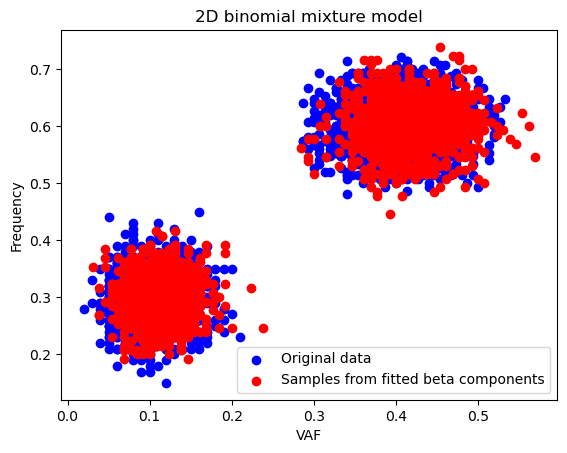

In [176]:
# Plot histogram of data

# DP = 130
NV_S1 = NV[:,0]
NV_S2 = NV[:,1]

DP_S1 = DP[:,0]
DP_S2 = DP[:,1]
plt.scatter(NV_S1/DP_S1, NV_S2/DP_S2, c = 'b', label = "Original data")

# Plot samples from fitted densities
x = np.linspace(0, 150, 1000)
n = 130

f1 = torch.ones([1000, 2])
f1[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,0]).sample([1000]).squeeze(-1)
f1[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][0,1]).sample([1000]).squeeze(-1)
plt.scatter(f1[:,0]/n, f1[:,1]/n, c = 'r', label = "Samples from fitted beta components")

f2 = torch.ones([1000, 2])
f2[:,0] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,0]).sample([1000]).squeeze(-1)
f2[:,1] = dist.Binomial(total_count=n, probs=params["probs_bin"][1,1]).sample([1000]).squeeze(-1)
plt.scatter(f2[:,0]/n, f2[:,1]/n, c = 'r')

plt.title('2D binomial mixture model')
plt.xlabel('VAF')
plt.ylabel('Frequency')
plt.legend()
plt.show()